## Building a Convolutional Neural Network

The purpose of this file is to build a preliminary (version 0) convolutional neural network that can, when given a tensor consisting of a time-series plot of seven globally-mapped climate variables over time (anomalies to a base period, seasonality removed), outputs a probability between 0 and 1. (I don't understand how it knows the probability is whether it's from a given time period? What is it outputting right now as is?) 

In [6]:
# IMPORT STATEMENTS
import numpy as np
import tensorflow as tf # Use version 2.15.0 due to a MaxPooling2D bug associated with odd dimensions in 2.18.0
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Check tf version
print(tf.__version__)

2.15.0


In [3]:
# Use the %run magic command to access the contents of the time series plot file
%run ./global_map_script_cnk_copy.ipynb

Instructions for updating:
non-resource variables are not supported in the long term
2.15.0


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Mean of empty slice
Mean of empty slice
Mean of empty slice


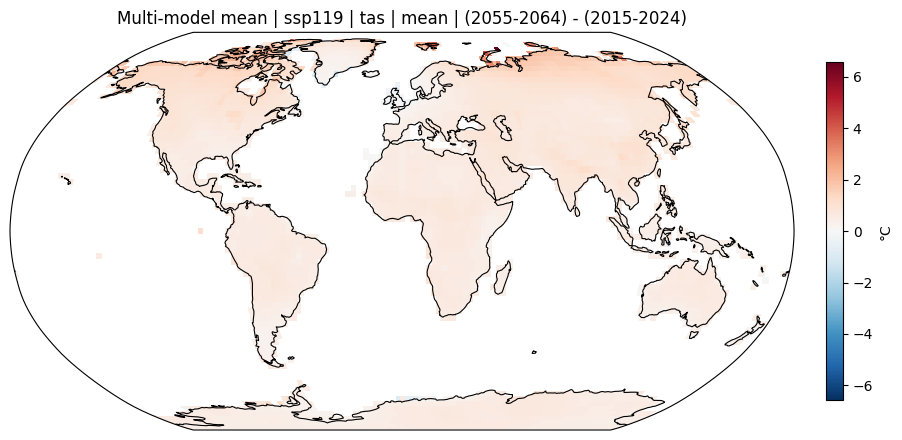

In [4]:
# Creating tensors - global plots of various climate anomalies over time

#Tensor 1: Multimodel mean global tas (2055 to 2064 minus 2015 to 2024)
tas119 = script1_global_map(
         varname="tas",
         scenario="ssp119",
         period1=(2015, 2024),
         period2=(2055, 2064),
         stat="mean",
         multimodel=True,
         model_name=None
     )

In [5]:
# Clear old layers
tf.keras.backend.clear_session()

# Create a class to build blocks that will go into the CNN 
class ConvBlock(layers.Layer):
    """This class builds 2 convolutional layers and 1 max pooling layer that function as a single block"""
    
    # Initialization
    def __init__(self, num_kernels, kernel_size=(3,3)):
        # Call the parent class in Keras
        super().__init__() 
        # Do not define input shape; let this be done automatically
        # Define layers
        self.conv1 = layers.Conv2D(num_kernels, kernel_size, strides=1, padding='same', activation='relu')
        self.conv2 = layers.Conv2D(num_kernels, kernel_size, strides=1, padding='same', activation='relu')
        self.pool = layers.MaxPooling2D((2, 2), padding='same')

    # Forward pass
    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return self.pool(x)

# Subclassing API breaks with odd dimensions, use the Functional API instead

# Create a class to build the overall CNN
class CNK_CNN(models.Model):

    # Initialization
    def __init__(self):
        # Call the parent class
        super().__init__()
        # Define input shape 
        self.input_layer = layers.Input(shape=(144, 73, 7))
        # Define the blocks
        self.block1 = ConvBlock(64)
        self.block2 = ConvBlock(32)
        self.block3 = ConvBlock(16)
        # Create a layer to flatten
        self.flatten = layers.Flatten()
        # Create dense layers
        self.dense1 = layers.Dense(50, activation='relu')
        self.dense2 = layers.Dense(10, activation='relu')
        self.dense3 = layers.Dense(1, activation='sigmoid')

    # Forward pass
    def call(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return x

# Create the model instance
model = CNK_CNN()

# Create a dummy tensor 
dummy_x = tf.zeros((1, 144, 73, 7), dtype=tf.float32)

# Perform a forward pass with the dummy tensor to jumpstart the build
_ = model(dummy_x)

# Show a model summary
model.summary()

Model: "cnk_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_block (ConvBlock)      multiple                  41024     
                                                                 
 conv_block_1 (ConvBlock)    multiple                  27712     
                                                                 
 conv_block_2 (ConvBlock)    multiple                  6944      
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  144050    
                                                                 
 dense_1 (Dense)             multiple                  510       
                                                                 
 dense_2 (Dense)             multiple                  11  

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(train_images, train_labels, epochs=20, batch_size=32,
                    validation_data=(val_images, val_labels),
                    callbacks=[early_stopping], verbose=2)
